# Lesson 3: Under the Hood: Training a Digit Classifier

This notebook will go over *some* of the practical material discussed in [lesson 3](https://course.fast.ai/videos/?lesson=1) of the fastai 2020 course, namely, some different ways of training a digit classifier using the MNIST data set.

## Primer
- load in some data
- visualise it

In [1]:
from fastai.vision.all import *
from pathlib import Path

For this model we are going to create a digit classifier that will be able to classify an image as a 3 or a 7. Fastai has a sample of the MNIST dataset that we will be using.

First, let's load the data and check that there are indeed, 3's an 7's in one of the folders. The folder layout is fairly typical, separate training and validation sets.

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
(path/'train').ls()

(#2) [Path('/storage/data/mnist_sample/train/7'),Path('/storage/data/mnist_sample/train/3')]

### Visualising Data

There are a number of ways we can check our data to get a better understanding of how it is structured and how it looks

1. Take a look inside one of the folders and check file names
2. Use PIL to open one of the images
3. Use PyTorch/Numpy to check the tensor/array values
4. Get creative

In [4]:
# 1 - check file names
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/storage/data/mnist_sample/train/3/10.png'),Path('/storage/data/mnist_sample/train/3/10000.png'),Path('/storage/data/mnist_sample/train/3/10011.png'),Path('/storage/data/mnist_sample/train/3/10031.png'),Path('/storage/data/mnist_sample/train/3/10034.png'),Path('/storage/data/mnist_sample/train/3/10042.png'),Path('/storage/data/mnist_sample/train/3/10052.png'),Path('/storage/data/mnist_sample/train/3/1007.png'),Path('/storage/data/mnist_sample/train/3/10074.png'),Path('/storage/data/mnist_sample/train/3/10091.png')...]

In [5]:
# 2 - use PIL to open image
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [6]:
# 3 - use PyTorch to view tensor values
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [7]:
# 4 - Getting creative with Pandas
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


### Sidebar - think about the problem

Before jumping into solution mode (ie apply deep learning to everything!) think about the problem space and how you might be able to solve it. 

For this problem (digit recognition) using a simple average might be enough to get a descent result. That is exactly what we will do first.

# Method 1: Pixel Similarity

- find the average pixel value for every pixel of the 3s and 7s
    - this will give us 2 group averages that represent the "ideal" 3 and 7
- to classify a digit, check the similarity against the ideal
- this method will form our baseline that we will improve upon later

### Step 1: Organise data
- create a tensor by stacking all of our 3s together
    - we will use list comprehension for this

In [8]:
# open all images, convert to tensor, store in list

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

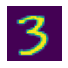

In [9]:
# lets check one of
show_image(three_tensors[1]);

### Step 2: Compute the average pixel value

- For every pixel position, compute the average over all the images of the intensity of that pixel.
- To do this
    - combine all images into a single 3-dimensional tensor using [`stack`](https://pytorch.org/docs/stable/generated/torch.stack.html) which  "*Concatenates sequence of tensors along a new dimension*."
    - PuyTorch needs us to cast the `int` values to floats in order to compute the average.
    - "Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here" [source](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb)

In [10]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

`tensor` jargon
- *rank*: the number of axis
- *shape*: the size of each axis

In [11]:
print('rank:',stacked_threes.ndim,'\n',
      'shape:', stacked_threes.shape)

rank: 3 
 shape: torch.Size([6131, 28, 28])


We have 6,131 images of size 28x28 

### Step 3: Compute the ideal digits

- compute the mean along the 0th dimension
- by visualising this ideal 3 we can indeed see that it represents a 3!

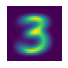

In [50]:
mean3 = stacked_threes.mean(dim=0)
show_image(mean3);

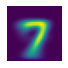

In [13]:
mean7 = stacked_sevens.mean(dim=0)
show_image(mean7);

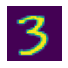

In [14]:
# here is a random three for comparison
a_3 = stacked_threes[1]
show_image(a_3);

How could we calculate how similar a 3 is from this ideal 3? Typically there are two methods

- take the absolute value of differences (where there are negatives, replace with postive)
    - This is called the *mean absolute difference* or *L1 norm*
- take the mean squared difference (which also makes all results positive) then take the square root
    - This is called the *root mean squared error (RMSE)* or *L2 norm*.
  

In [15]:
# 3
# L1 Norm
# mean absolute difference

dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [16]:
# 7
# L1 Norm
# mean absolute difference

dist_3_abs = (a_3 - mean7).abs().mean()
dist_3_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1586), tensor(0.3021))

The distance between our "ideal" 3 and the real 3 is less than the distance from the real 3 to "ideal" 7. This is good - it means both methods will work and our simple model will give the correct prediction.

PyTorch already provides these loss functions for us (though RMSE is only MSE, but we can work with that).

In [17]:
# check results with PyTorch

F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### A simple model

A validation set is usually used to help avoid overfitting, our model has no trained components so this isn't going to be an issue, but let's stick with best practices.

We will also define a function that will decide if an arbitrary image is a 3 or a 7. This will be achieved by measuring the distance between this digit and our ideal digits and determining which ideal it is closer to. 


In [18]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

`mnist_distance` calculates the difference between our ideal 3 and every 3 in the validation set. 

We call `mean((-1,-2))` in our fuction. The tuple `(-1,-2)` represents a range of axes, so the last -1, and second last -2. `mean((-1,-2))` says; take the mean over the last two axes in the tensor. Why? These axes represent the verticle and horizontal dimensions of an image. After taking the mean over the these axes, we have one axis left which indexes over the 1,010 images we have. 

In [40]:
# calculate the mean absolute error

def mnist_distance(a,b):
    return (a-b).abs().mean((-1,-2))

# check the function
mnist_distance(a_3, mean3) # great!

tensor(0.1114)

This works for a single image, but in order to calculate the overall accuracy, we want to calculate this distance to the ideal 3 for all images in the validation set. This can be achieved using a loop, but there is another way - broadcasting.

Take a look at the shape of `valid_3_tens` and `mean3`, they are different...

In [24]:
valid_3_tens.shape, mean3.shape

(torch.Size([1010, 28, 28]), torch.Size([28, 28]))

Now calculate the distance between the two...

In [25]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)

valid_3_dist, valid_3_dist.shape

(tensor([0.1290, 0.1223, 0.1380,  ..., 0.1337, 0.1132, 0.1097]),
 torch.Size([1010]))

our function has returned the distance for every single image as a rank-1 tensor of length 1,010. 

This is because we have added a subtraction `(a-b)` into our distance function and when PyTorch performs this subtraction, it uses *broadcasting* which will automatically expand the tensor with smaller rank to have the same size as the one with larger rank. Once this has happened, PyTorch will perform an element wise operation over the two tensors. 

In our case, PyTorch is treating `mean3` (a rank 2 tensor) as if it were 1,010 copies of that tensor.

You can see that by performing a subtraction and checking the shape

In [29]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

There are a couple of important points about how broadcasting is implemented, which make it valuable not just for expressivity but also for performance:

- PyTorch doesn't actually copy mean3 1,010 times. It pretends it were a tensor of that shape, but doesn't actually allocate any additional memory
- It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).

[source](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb)

### A funtion to make a decision 

`is_3` is going to use `mnist_distance` to figure out whether an image is a 3 or a 7. To do this it will check whether the distance between a digit, x and `mean3` is less than the difference between x and `mean7`.

In [43]:
def is_3(x): 
    return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [44]:
# let's test it
# you can convert a boolean to a float 

is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

Calculate the accuracy for each 3 and 7 by taking the average of `is_3` for all 3s and it's inverse for all 7s. 

In [46]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

Not bad, over 90% accuracy using a very simple model. This was also a very simple problem, 3s and 7s look very different so it's not really a surprise that this was so effective. 

We will nowe look at a system that will do some learning (automatically modify itself to improve its performance)

In the next part, we will implement this more advanced model